#### A Telecom company is losing Customers to its competitors. With the historical customer churn information that they have, they want a ML Model to predict, which of their present customers may churn.

We have decided to create a `Logistic Regression` model to solve the problem. The Logistic Regression model will be expected to output a `Churn Probability` for every data under test.

The input data is spread over 3 separate files - `churn_data.csv`, `cust_data.csv` and `internet_data.csv`.

The Data includes the following:

- `Personal Data (gender, children, whether senior citizen, dependents...)`
- `Services Related (Tenure with the provider, payment method, internet packs purchased, special offers...)`
- `Charges being incurred (Amount of recharge done per month...)`

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as smd
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
churn_data = pd.read_csv('churn_data.csv')
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
customer_data = pd.read_csv("customer_data.csv")
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [4]:
internet_data = pd.read_csv("internet_data.csv")
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


### Merge the Input Datasets into one based on "Customer Id"

In [5]:
# Merging on 'customerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')

In [6]:
# Final dataframe with all predictor variables
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')

In [7]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [8]:
telecom.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [9]:
# Let's check the dimensions of the dataframe
telecom.shape

(7043, 21)

In [10]:
# let's look at the statistical aspects of the dataframe
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [11]:
# Let's see the type of each column
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


### Data Pre-processing

#### Pre-process the Total Charges Feature

In [12]:
telecom['TotalCharges'] = telecom['TotalCharges'].replace(' ', np.nan) # replace empty strings with Na
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges']) # convert TotalCharges to numeric 

Total Charges will be related to Monthly Charges.
We will impute Total charges multiplied by median of the ratio of Total charges to monthly charges

In [13]:
value = telecom['MonthlyCharges'] * telecom['tenure']

here we have totalcharges and value clumn suppose we have null value of 87 no. to fill tha null value we will use value column to fill the null value of total charges column but if we have any value in total charges column then we will not change that value and keep it as it is

In [14]:
telecom['TotalCharges'] = value.where(telecom['TotalCharges'] == np.nan, other=telecom['TotalCharges']) 

In [15]:
telecom['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

## Exploratory Data Analysis (EDA)
The EDA process will comprise of Univariate and Multivariate Analysis alomg with abundant Visualisations.  

### Univariate Analysis

(array([2709., 1228.,  671.,  508.,  454.,  412.,  395.,  310.,  223.,
         122.]),
 array([  18.8,  885.4, 1752. , 2618.6, 3485.2, 4351.8, 5218.4, 6085. ,
        6951.6, 7818.2, 8684.8]),
 <BarContainer object of 10 artists>)

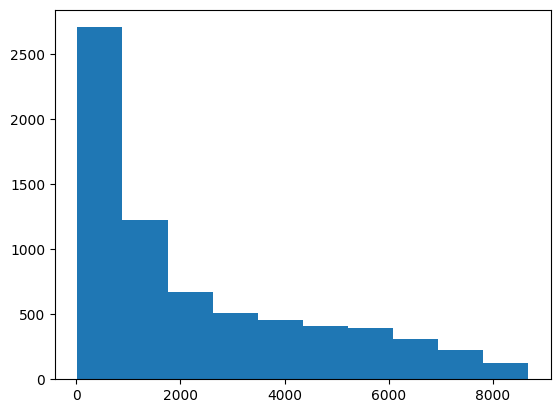

In [16]:
# Distribution of Total Charges Field
plt.hist(telecom['TotalCharges'])

#### Churn Split in terms of Counts

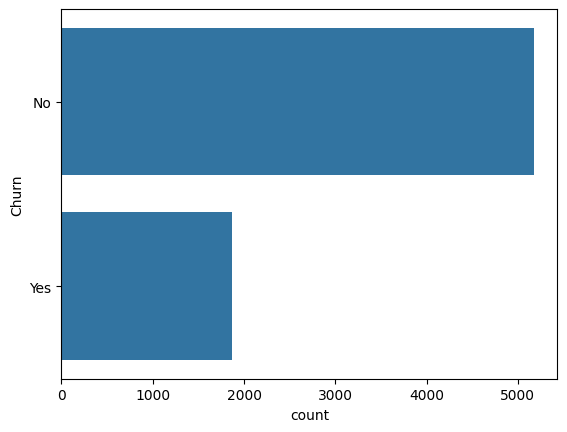

In [17]:
# Display the counts of Churns in the entire data. This provides an indication of whether the data is unbalanced. (this plot showes imbalance in data)
plt1 = sns.countplot(telecom['Churn'])

Tenure (The time for which a customer has been using the service.)

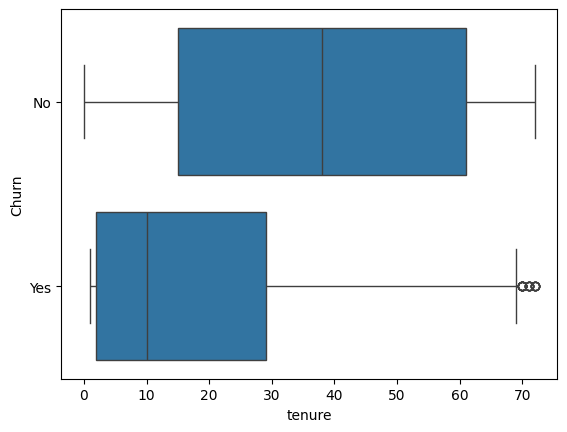

In [18]:
sns.boxplot(x = 'tenure', y = 'Churn', data = telecom)
## or you may write this:  sns.boxplot(x=telecom["tenure"],y=telecom["churn"])
plt.show()
# this plot shows Customer with more tenure tends to churn less.

In [19]:
telecom["Contract"].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [20]:
telecom[telecom['Contract'] == "Month-to-month"]["Churn"].value_counts()

Churn
No     2220
Yes    1655
Name: count, dtype: int64

### Find for which kind of Contracts the churn probability is more

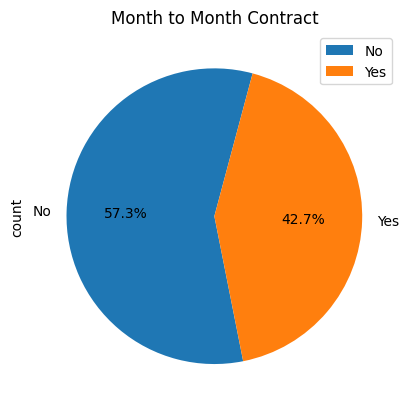

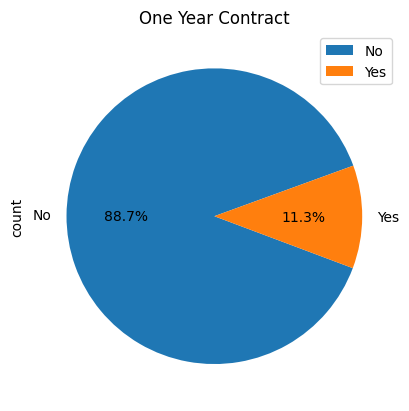

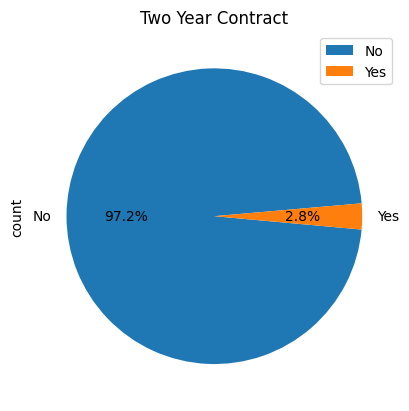

In [21]:
pie_Contract_m2m = pd.DataFrame(telecom[telecom['Contract'] == "Month-to-month"]['Churn'].value_counts())
pie_Contract_m2m.plot.pie(subplots=True, labels = pie_Contract_m2m.index.values, autopct='%1.1f%%', startangle= 75)
plt.title('Month to Month Contract')
plt.gca().set_aspect('equal')

pie_Contract_1y = pd.DataFrame(telecom[telecom['Contract'] == "One year"]['Churn'].value_counts())
pie_Contract_1y.plot.pie(subplots=True, labels = pie_Contract_1y.index.values, autopct='%1.1f%%', startangle= 20)
plt.title('One Year Contract')
plt.gca().set_aspect('equal')

pie_Contract_2y = pd.DataFrame(telecom[telecom['Contract'] == "Two year"]['Churn'].value_counts())
pie_Contract_2y.plot.pie(subplots=True, labels = pie_Contract_2y.index.values, autopct='%1.1f%%', startangle= 5)
plt.title('Two Year Contract')
plt.gca().set_aspect('equal')

plt.show()

# these pie charts shows Customers with One Year and Two year contract tends to Churn a lot lesser than month to month contract.

### Whether being on Monthly Charges is influencing Churn

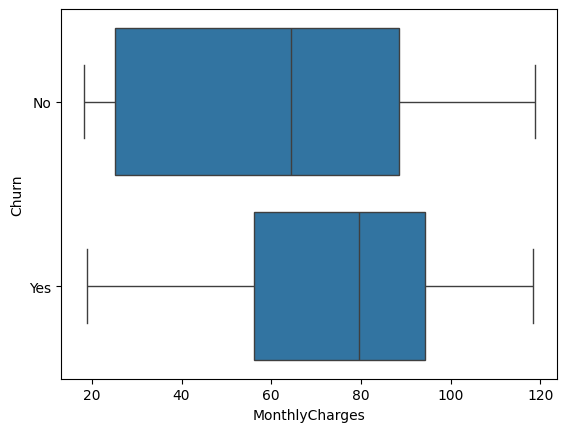

In [22]:
sns.boxplot(x = 'MonthlyCharges', y = 'Churn', data = telecom)
plt.show()
# this plot shows Median monthly charges are higher for customers who have churned.

### Whether TotalCharges amount has influence on Churn

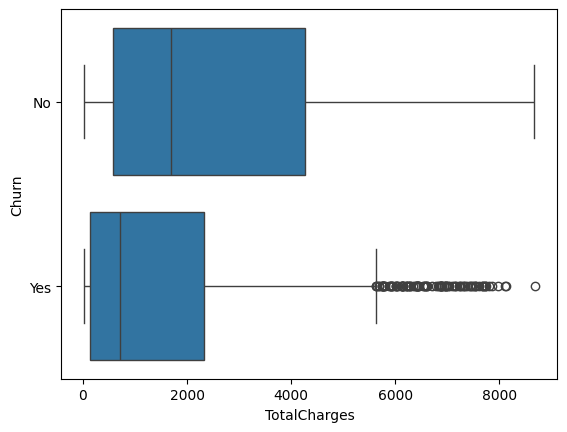

In [23]:
sns.boxplot(x = 'TotalCharges', y = 'Churn', data = telecom)
plt.show()
# this plot shows # Median Total charges are low for customers who have churned.

### Whether having Multiple Internet Connections have influence on Churn

<Figure size 1500x500 with 0 Axes>

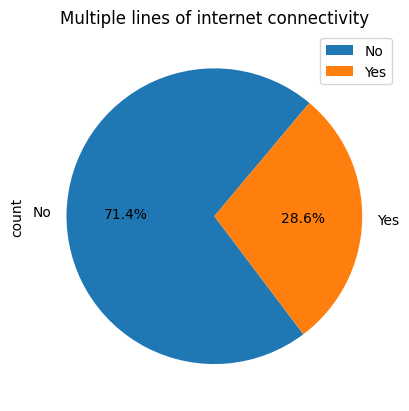

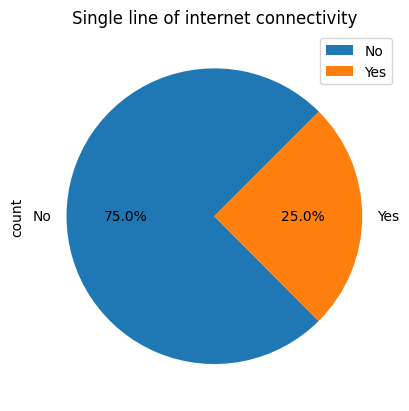

In [24]:
# Whether a customer has multiple lines of internet connectivity.
plt.figure(figsize=(15,5))
pie_MultipleLines_Y = pd.DataFrame(telecom[telecom['MultipleLines'] == 'Yes']['Churn'].value_counts())
pie_MultipleLines_Y.plot.pie(subplots = True,  labels = pie_MultipleLines_Y.index.values, autopct='%1.1f%%', startangle= 50)
plt.title('Multiple lines of internet connectivity')
plt.gca().set_aspect('equal')

pie_MultipleLines_N = pd.DataFrame(telecom[telecom['MultipleLines'] == 'No']['Churn'].value_counts())
pie_MultipleLines_N.plot.pie(subplots = True,  labels = pie_MultipleLines_N.index.values, autopct='%1.1f%%', startangle= 45)
plt.title('Single line of internet connectivity')

plt.gca().set_aspect('equal')
plt.show()

# this pie chart shows # Multiple lines of internet connectivity doesn't effect churn that much.

### Whether type of Internet Service has influence on Churn

<Figure size 1500x500 with 0 Axes>

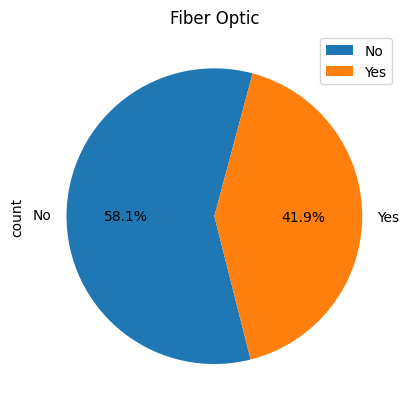

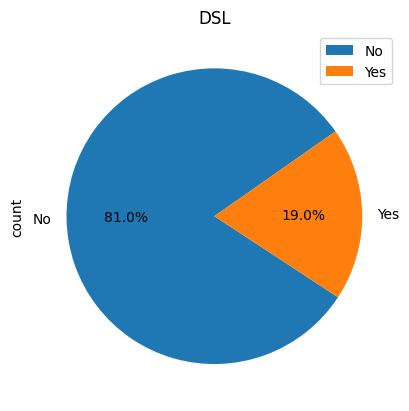

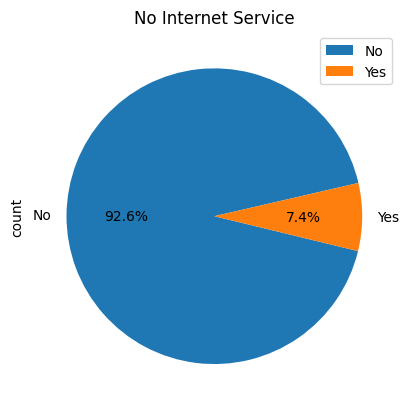

In [25]:
plt.figure(figsize=(15,5))
pie_InternetService_fo = pd.DataFrame(telecom[telecom['InternetService'] == "Fiber optic"]['Churn'].value_counts())
pie_InternetService_fo.plot.pie(subplots = True, labels = pie_InternetService_fo.index.values, autopct='%1.1f%%', startangle= 75)
plt.title('Fiber Optic')
plt.gca().set_aspect('equal')

pie_InternetService_dsl = pd.DataFrame(telecom[telecom['InternetService'] == "DSL"]['Churn'].value_counts())
pie_InternetService_dsl.plot.pie(subplots = True, labels = pie_InternetService_dsl.index.values, autopct='%1.1f%%', startangle= 35)
plt.title('DSL')
plt.gca().set_aspect('equal')

pie_InternetService_no = pd.DataFrame(telecom[telecom['InternetService'] == "No"]['Churn'].value_counts())
pie_InternetService_no.plot.pie(subplots = True, labels = pie_InternetService_no.index.values, autopct='%1.1f%%', startangle= 13)
plt.title('No Internet Service')
plt.gca().set_aspect('equal')

plt.show()

# this pie chart shows Customers with Fiber Optic Connection churn the most whereas least probability of churning for those with no internet service.

### Convert Binary Categorical Features (Yes/No) to 0/1

In [26]:
# List of variables to map

varlist =  ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
telecom[varlist] = telecom[varlist].apply(binary_map)

In [27]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.50,0,Male,...,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,No,Fiber optic,No,No,No,No,No,No


### For Nominal Categorical Features with multiple possible values, create dummy variable (one-hot encoding)

In [28]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(telecom[['Contract', 'PaymentMethod', 'gender', 'InternetService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']], drop_first=True,dtype=float)

# Adding the results to the master dataframe
telecom = pd.concat([telecom, dummy1], axis=1)

### Dropping the Original Features

In [29]:
# We have created dummies for the below variables, so we can drop them
telecom = telecom.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],axis=1)

In [30]:
telecom.head()

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,34,1,0,56.95,1889.50,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2,1,1,53.85,108.15,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,45,0,0,42.30,1840.75,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9237-HQITU,2,1,1,70.70,151.65,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7032 non-null   float64
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   float64
 11  Cont

Now you can see that you have all variables as numeric.

#### Checking for Missing Values and Inputing Them

In [32]:
# Adding up the missing values (column-wise)
telecom.isnull().sum()

customerID                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
Contract_One year                         0
Contract_Two year                         0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
InternetService_Fiber optic               0
InternetService_No                        0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service

It means that 11/7043 = 0.001561834 i.e 0.1%, best is to remove these observations from the analysis

In [33]:
# Removing NaN TotalCharges rows
telecom = telecom[~np.isnan(telecom['TotalCharges'])] # here we are dropping the rows where TotalCharges is NaN

In [34]:
# Checking percentage of missing values after removing the missing values
round(100 * (telecom.isnull().sum() / len(telecom.index)), 2)

customerID                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
MultipleLines_No phone service           0.0
MultipleLines_Yes                        0.0
OnlineSecurity_No internet service       0.0
OnlineSecurity_Yes                       0.0
OnlineBack

## Test-Train Split of Input Dataset

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Putting feature variable to X
X = telecom.drop(['customerID'], axis=1)
y = X.pop('Churn')

In [37]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler = StandardScaler()

X_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])

X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
879,0.019693,1,1,-0.338074,-0.276449,0,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5790,0.305384,0,1,-0.464443,-0.112702,0,1,1,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6498,-1.286319,1,1,0.581425,-0.974430,0,0,0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
880,-0.919003,1,1,1.505913,-0.550676,0,0,0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2784,-1.163880,1,1,1.106854,-0.835971,0,0,1,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


## Finding Correlations among Features

In [40]:
cor = telecom.select_dtypes(include=[np.number]).corr()
cor

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
tenure,1.000000,0.007877,0.004823,0.246862,0.825880,-0.354049,0.015683,0.381912,0.163386,0.202338,...,-0.037529,0.361138,-0.037529,0.361520,-0.037529,0.325288,-0.037529,0.280264,-0.037529,0.285402
PhoneService,0.007877,1.000000,0.016696,0.248033,0.113008,0.011691,0.008392,0.018397,-0.001078,-0.003142,...,0.171817,-0.052133,0.171817,-0.070076,0.171817,-0.095138,0.171817,-0.021383,0.171817,-0.033477
PaperlessBilling,0.004823,0.016696,1.000000,0.351930,0.157830,0.191454,0.156258,-0.013957,-0.110131,-0.052278,...,-0.320592,0.127056,-0.320592,0.104079,-0.320592,0.037536,-0.320592,0.224241,-0.320592,0.211583
MonthlyCharges,0.246862,0.248033,0.351930,1.000000,0.651065,0.192858,0.219874,0.097825,-0.112343,0.004810,...,-0.763191,0.441529,-0.763191,0.482607,-0.763191,0.338301,-0.763191,0.629668,-0.763191,0.627235
TotalCharges,0.825880,0.113008,0.157830,0.651065,1.000000,-0.199484,0.102411,0.319072,0.064653,0.170569,...,-0.374878,0.510100,-0.374878,0.522881,-0.374878,0.432868,-0.374878,0.515709,-0.374878,0.519867
Churn,-0.354049,0.011691,0.191454,0.192858,-0.199484,1.000000,0.150541,-0.149982,-0.163128,-0.178225,...,-0.227578,-0.082307,-0.227578,-0.066193,-0.227578,-0.164716,-0.227578,0.063254,-0.227578,0.060860
SeniorCitizen,0.015683,0.008392,0.156258,0.219874,0.102411,0.150541,1.000000,0.016957,-0.210550,-0.046491,...,-0.182519,0.066663,-0.182519,0.059514,-0.182519,-0.060577,-0.182519,0.105445,-0.182519,0.119842
Partner,0.381912,0.018397,-0.013957,0.097825,0.319072,-0.149982,0.016957,1.000000,0.452269,0.083067,...,-0.000286,0.141849,-0.000286,0.153556,-0.000286,0.120206,-0.000286,0.124483,-0.000286,0.118108
Dependents,0.163386,-0.001078,-0.110131,-0.112343,0.064653,-0.163128,-0.210550,0.452269,1.000000,0.069222,...,0.138383,0.023639,0.138383,0.013900,0.138383,0.063053,0.138383,-0.016499,0.138383,-0.038375
Contract_One year,0.202338,-0.003142,-0.052278,0.004810,0.170569,-0.178225,-0.046491,0.083067,0.069222,1.000000,...,0.038061,0.084113,0.038061,0.102911,0.038061,0.096258,0.038061,0.061930,0.038061,0.064780


In [41]:
# Find out the Fields with high correlation

correlated_features = set()
for i in range(len(cor.columns)):
    for j in range(i):
        if abs(cor.iloc[i, j]) > 0.7:
            colname1 = cor.columns[i]
            colname2 = cor.columns[j]
            print(abs(cor.iloc[i, j]), "--", i, '--', j, '--', colname1, '--', colname2)
            correlated_features.add(colname1)
            correlated_features.add(colname2)

0.8258804609332019 -- 4 -- 0 -- TotalCharges -- tenure
0.7871948529419366 -- 15 -- 3 -- InternetService_Fiber optic -- MonthlyCharges
0.7631910615169536 -- 16 -- 3 -- InternetService_No -- MonthlyCharges
1.0000000000000002 -- 17 -- 1 -- MultipleLines_No phone service -- PhoneService
0.7631910615169536 -- 19 -- 3 -- OnlineSecurity_No internet service -- MonthlyCharges
1.0 -- 19 -- 16 -- OnlineSecurity_No internet service -- InternetService_No
0.7631910615169536 -- 21 -- 3 -- OnlineBackup_No internet service -- MonthlyCharges
1.0 -- 21 -- 16 -- OnlineBackup_No internet service -- InternetService_No
1.0 -- 21 -- 19 -- OnlineBackup_No internet service -- OnlineSecurity_No internet service
0.7631910615169536 -- 23 -- 3 -- DeviceProtection_No internet service -- MonthlyCharges
1.0 -- 23 -- 16 -- DeviceProtection_No internet service -- InternetService_No
1.0 -- 23 -- 19 -- DeviceProtection_No internet service -- OnlineSecurity_No internet service
1.0 -- 23 -- 21 -- DeviceProtection_No interne

In [42]:
print(cor.columns)
print('------')
print(correlated_features)

Index(['tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'SeniorCitizen', 'Partner', 'Dependents',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')
------
{'OnlineBackup_No internet service', 'InternetService_Fiber optic', 'TotalCharges', 'MultipleLines_No phone service', 'OnlineSec

#### Dropping highly correlated dummy variables

In [43]:
X_test = X_test.drop(['TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'StreamingMovies_No internet service',
                'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'DeviceProtection_No internet service'],axis= 1)
X_train = X_train.drop(['TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'StreamingMovies_No internet service',
                'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'DeviceProtection_No internet service'],axis= 1)

### Repeat the Correlation Matrix/Heatmap

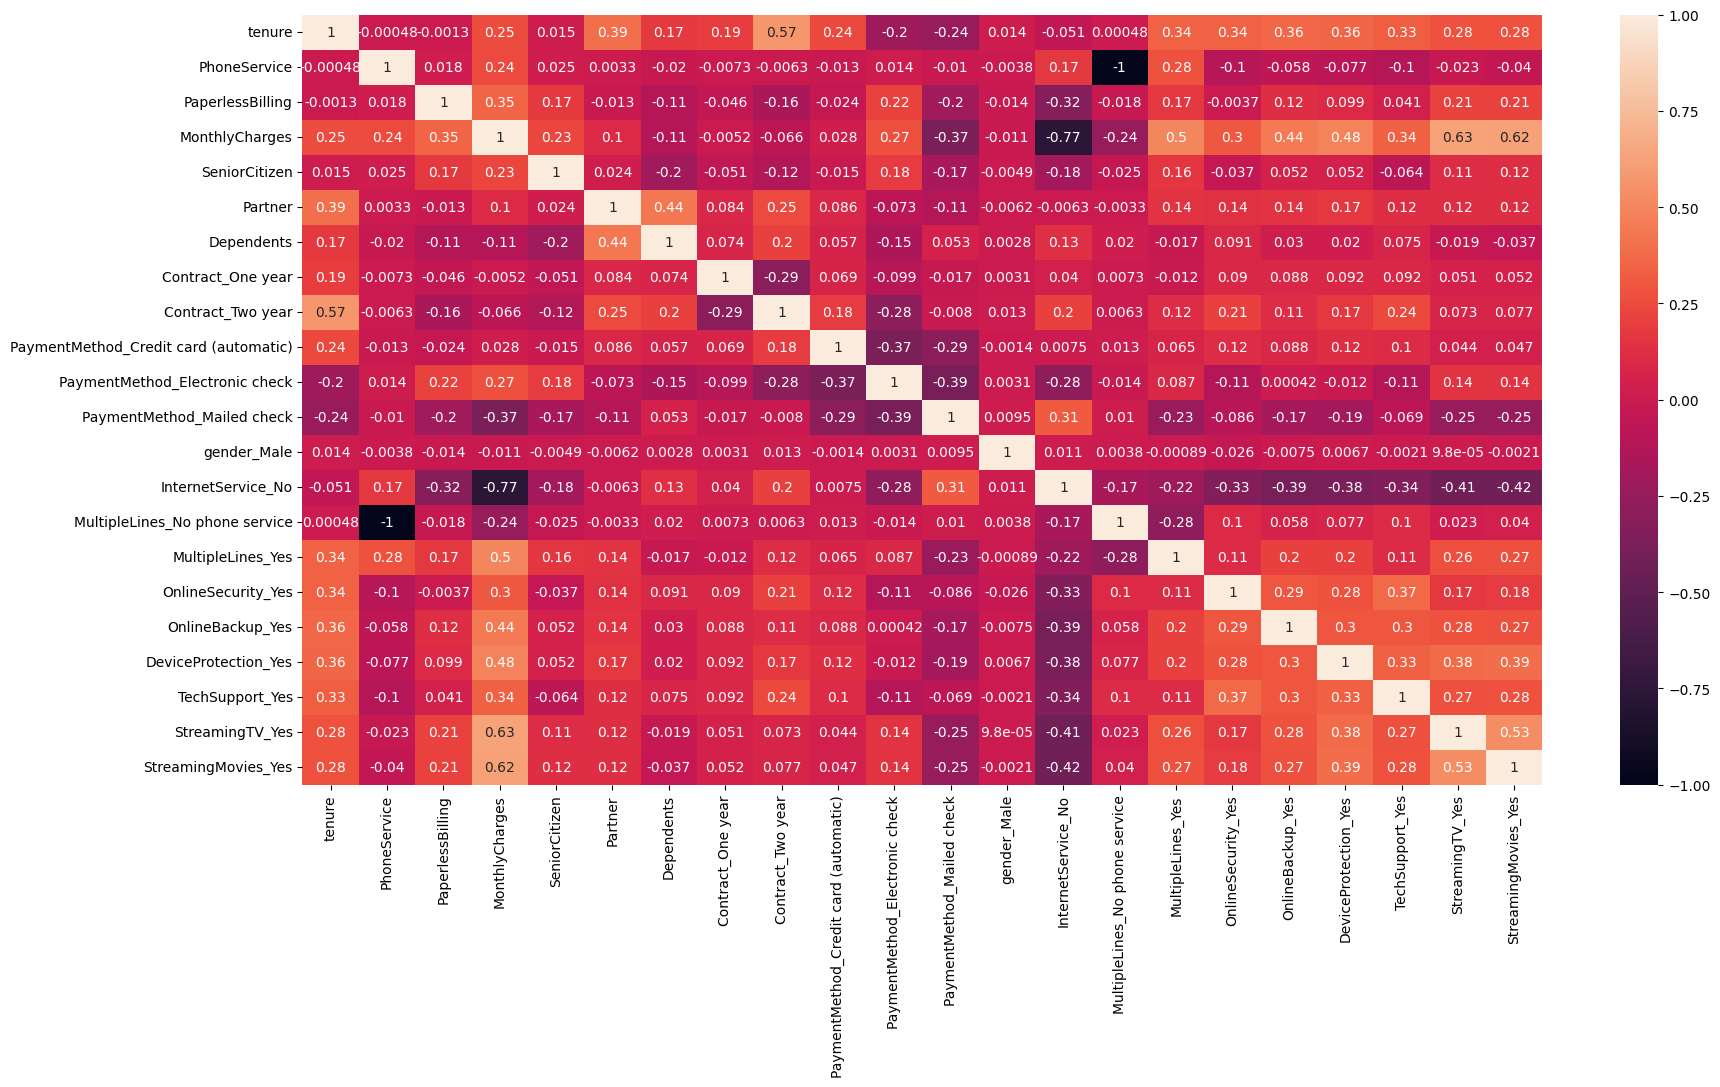

In [44]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()

## Create our Logistic Regression Model

### `add_constant()`
By default, statsmodels fits a line passing through the origin, i.e. it doesn't fit an intercept. Hence, you need to use thecommand 'add_constant' so that it also fits an intercept.

In [45]:
from statsmodels.tools import add_constant as add_constant
X_train_constant = add_constant(X_train)
X_train_constant.head()

,const,tenure,PhoneService,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,gender_Male,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
879,1.0,0.019693,1,1,-0.338074,0,0,0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5790,1.0,0.305384,0,1,-0.464443,0,1,1,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
6498,1.0,-1.286319,1,1,0.581425,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
880,1.0,-0.919003,1,1,1.505913,0,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2784,1.0,-1.163880,1,1,1.106854,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [46]:
cols = X_train_constant.columns
model = smd.Logit(y_train, X_train_constant[cols])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.409390
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4899
Method:                           MLE   Df Model:                           22
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.2875
Time:                        10:01:52   Log-Likelihood:                -2015.0
converged:                       True   LL-Null:                       -2828.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.3258        nan        nan        nan         nan         nan
tenure                                   -0.8802      0.071    -12.391      0.000      -1.019      -0.741
PhoneService                             -0.6654        nan        nan        nan         nan         nan
PaperlessBilling                          0.3230      0.090      3.600      0.000       0.147       0.499
MonthlyCharges                            1.0009      0.131      7.626      0.000       0.744       1.258
SeniorCitizen                             0.4013      0.102      3.940      0.000       0.202       0.601
Partner                                   0.0453      0.093      0.485      0.628      -0.138       0.228
Dependents                               -0.1650      0.107     -1.542      0.123      -0.375       0.045
Contract_One year                        -0.6685      0.128     -5.231      0.000      -0.919      -0.418
Contract_Two year                        -1.2156      0.210     -5.800      0.000      -1.626      -0.805
PaymentMethod_Credit card (automatic)    -0.2565      0.137     -1.877      0.061      -0.524       0.011
PaymentMethod_Electronic check            0.1743      0.113      1.548      0.122      -0.046       0.395
PaymentMethod_Mailed check               -0.1972      0.136     -1.453      0.146      -0.463       0.069
gender_Male                              -0.0342      0.078     -0.437      0.662      -0.188       0.119
InternetService_No                       -0.1717      0.228     -0.752      0.452      -0.619       0.276
MultipleLines_No phone service            0.3396        nan        nan        nan         nan         nan
MultipleLines_Yes                         0.0917      0.100      0.919      0.358      -0.104       0.287
OnlineSecurity_Yes                       -0.5086      0.103     -4.961      0.000      -0.710      -0.308
OnlineBackup_Yes                         -0.2920      0.094     -3.116      0.002      -0.476      -0.108
DeviceProtection_Yes                     -0.1599      0.097     -1.645      0.100      -0.350       0.031
TechSupport_Yes                          -0.5195      0.101     -5.136      0.000      -0.718      -0.321
StreamingTV_Yes                          -0.0122      0.108     -0.113      0.910      -0.224       0.199
StreamingMovies_Yes                      -0.1224      0.108     -1.139      0.255      -0.333       0.088
=========================================================================================================
"""

### Feature Selection: Drop Features with P-Value > 0.05

In [47]:
drop_cols = ['PhoneService', 'Partner', 'Dependents', 'PaymentMethod_Electronic check',
             'PaymentMethod_Mailed check', 'gender_Male', 'InternetService_No', 'MultipleLines_No phone service',
             'MultipleLines_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes']

In [48]:
X_train_constant.drop(drop_cols, axis=1, inplace=True)

### Recreate the Logit Model with updated set of columns

In [49]:
model = smd.Logit(y_train, X_train_constant)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.416361
         Iterations 8


In [50]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4910
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.2754
Time:                        10:01:52   Log-Likelihood:                -2049.3
converged:                       True   LL-Null:                       -2828.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.0526      0.107     -9.807      0.000      -1.263      -0.842
tenure                                   -0.8509      0.065    -13.127      0.000      -0.978      -0.724
PaperlessBilling                          0.4084      0.088      4.629      0.000       0.235       0.581
MonthlyCharges                            0.8798      0.061     14.428      0.000       0.760       0.999
SeniorCitizen                             0.5129      0.099      5.174      0.000       0.319       0.707
Contract_One year                        -0.8013      0.125     -6.415      0.000      -1.046      -0.556
Contract_Two year                        -1.4307      0.206     -6.955      0.000      -1.834      -1.027
PaymentMethod_Credit card (automatic)    -0.3065      0.110     -2.779      0.005      -0.523      -0.090
OnlineSecurity_Yes                       -0.4558      0.101     -4.501      0.000      -0.654      -0.257
OnlineBackup_Yes                         -0.2126      0.093     -2.292      0.022      -0.394      -0.031
TechSupport_Yes                          -0.5082      0.100     -5.064      0.000      -0.705      -0.312
StreamingMovies_Yes                       0.0435      0.098      0.442      0.658      -0.149       0.236
=========================================================================================================
"""

### Now that we Optimized our model using Statsmodel Logit(), we will create a corresponding model using ScikitLearn LogisticRegression()
#### Some Differences between Logit and LogisticRegression
- ScikitLearn LogisticRegression: Uses L2 regularization by default, but regularization can be turned off using penalty=’none’.
StatsModel Logit: Does not use regularization by default.
- ScikitLearn LogisticRegression: Includes intercept by default.
StatsModel Logit: Use the add_constant method to include an intercept.


In [51]:
cols_model = ['tenure', 'PaperlessBilling', 'MonthlyCharges',
             'SeniorCitizen', 'Contract_One year', 'Contract_Two year',
             'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
             'TechSupport_Yes', 'StreamingMovies_Yes']

In [52]:
X_train1 = X_train_constant[cols_model]

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train1, y_train)

LogisticRegression()

In [54]:
dir(logreg)

['C',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual'

### Predict using Training Data

In [55]:
y_train_pred = logreg.predict(X_train1) # this will give us the predicted values for the training set

In [56]:
y_train

879     0
5790    0
6498    1
880     1
2784    1
       ..
79      0
3934    0
5964    0
6947    0
5649    0
Name: Churn, Length: 4922, dtype: int64

In [57]:
sklearn.metrics.accuracy_score(y_train, y_train_pred)

0.8033319788703779

<Axes: >

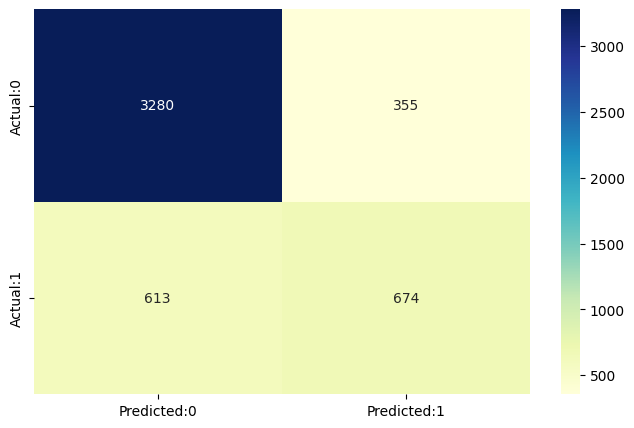

In [58]:
# Create the Confusion Matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [59]:
tn, fp, fn, tp = confusion_matrix(y_train,y_train_pred).ravel()
tn, fp, fn, tp

(np.int64(3280), np.int64(355), np.int64(613), np.int64(674))

In [60]:
recall=tp/(tp+fn)
recall

np.float64(0.5236985236985237)

In [61]:
from sklearn.metrics import precision_score
precision_score(y_train,y_train_pred)

0.6550048590864918

In [62]:
from sklearn.metrics import f1_score
f1_score(y_train,y_train_pred)

0.5820379965457686

### Other Classification Statistics

In [63]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [64]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'Missclassifications = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity/Recall or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Precision/Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.8033319788703779 
 Missclassifications = 1-Accuracy =  0.19666802112962212 
 Sensitivity/Recall or True Positive Rate = TP/(TP+FN) =  0.5236985236985237 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9023383768913342 
 Precision/Positive Predictive value = TP/(TP+FP) =  0.6550048590864918 
 Negative predictive Value = TN/(TN+FN) =  0.8425378885178526 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  5.362377841251079 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.5278523982792276


### Some Pointers from the above Classification Metrics:
- `Sensitivity/Recall`: In the example of Churn prediction, it gives us the percentage of Correctly Predicted Churns from the pool of Actual Churns.
- `Specificity`: Gives us the percentage of Correctly Predicted Non-Churns from the pool of Actual Non-Churns.
- `Precision`: Gives us the percentage of Correctly Predicted Churns from the pool of Total Predicted Churns.

### Plot the ROC Curve and AUC
The `ROC (Receiver Operating Characteristic)` Curve is an useful tool when predicting the probability of a binary outcome.

It is a plot of the `false positive rate (x-axis)` versus the `true positive rate (y-axis)` for a number of different candidate threshold values (probability) between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

An ROC curve demonstrates several things:

- It shows the `tradeoff between sensitivity and specificity` (any increase in sensitivity should be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test (higher AUC).
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [65]:
logreg.predict_proba(X_train1)[:,1]

array([0.23549978, 0.18392859, 0.67912939, ..., 0.06340602, 0.11060246,
       0.08413456], shape=(4922,))

Logistic: ROC AUC = 0.843


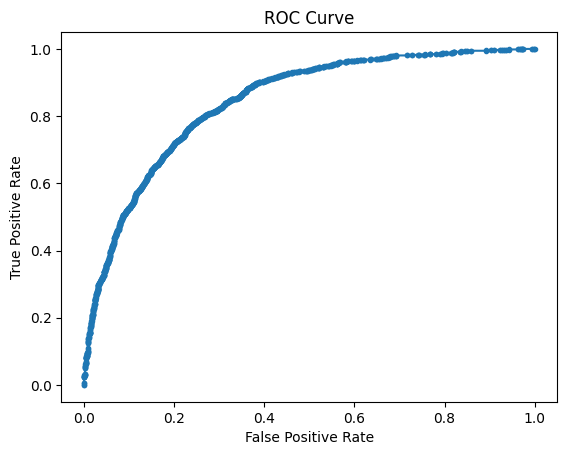

In [66]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
lr_probs = logreg.predict_proba(X_train1)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_train, lr_probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)

plt.plot(lr_fpr, lr_tpr, marker='.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

In [67]:
pd.DataFrame(zip(lr_fpr, lr_tpr), columns=('FPR', 'TPR'))

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.000777
2,0.000000,0.006216
3,0.000275,0.006216
4,0.000275,0.023310
...,...,...
1421,0.994498,1.000000
1422,0.995048,1.000000
1423,0.997799,1.000000
1424,0.998349,1.000000


### Creating a dataframe with the actual churn flag and the predicted probabilities

In [68]:
lr_probs[:5]

array([0.23549978, 0.18392859, 0.67912939, 0.58086994, 0.70092703])

In [69]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':lr_probs})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head(20)

,Churn,Churn_Prob,CustID
0,0,0.235500,879
1,0,0.183929,5790
2,1,0.679129,6498
3,1,0.580870,880
4,1,0.700927,2784
5,0,0.390582,3874
6,0,0.171004,5387
7,1,0.786016,6623
8,0,0.145823,4465
9,1,0.587700,5364


#### Observation from above Data: The 1's are assigned higher probability to the 0's. A good classification model will always try to assign higher numbers to the positive cases and assign lower numbers to negatives.


### Creating new column 'predicted' with `1 if Churn_Prob > 0.5 else 0`

In [70]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.235500,879,0
1,0,0.183929,5790,0
2,1,0.679129,6498,1
3,1,0.580870,880,1
4,1,0.700927,2784,1


In [71]:
from sklearn import metrics
# Create Confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[3280  355]
 [ 613  674]]


In [72]:
# Let's check the overall accuracy.
print(metrics.f1_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.5820379965457686


### Is our probability threshold of 0.5 good? Finding Optimal Cutoff Point...
Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [73]:
# Let's create columns with different probability cutoffs
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.235500,879,0,1,1,1,0,0,0,0,0,0,0
1,0,0.183929,5790,0,1,1,0,0,0,0,0,0,0,0
2,1,0.679129,6498,1,1,1,1,1,1,1,1,0,0,0
3,1,0.580870,880,1,1,1,1,1,1,1,0,0,0,0
4,1,0.700927,2784,1,1,1,1,1,1,1,1,1,0,0


In [74]:
numbers

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [75]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['threshold','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1

    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     threshold  accuracy     sensi     speci
0.0        0.0  0.261479  1.000000  0.000000
0.1        0.1  0.608696  0.940171  0.491334
0.2        0.2  0.704592  0.867910  0.646768
0.3        0.3  0.767980  0.751360  0.773865
0.4        0.4  0.793174  0.642580  0.846492
0.5        0.5  0.803332  0.523699  0.902338
0.6        0.6  0.794799  0.365967  0.946630
0.7        0.7  0.775498  0.188811  0.983219
0.8        0.8  0.747054  0.039627  0.997524
0.9        0.9  0.738521  0.000000  1.000000


### Plot `accuracy - sensitivity - specificity` against various probabilities.

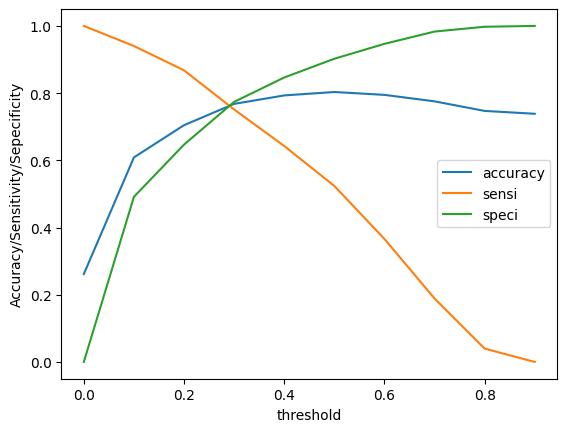

In [76]:
cutoff_df.plot.line(x='threshold', y=['accuracy','sensi','speci'])
plt.xlabel('threshold')
plt.ylabel('Accuracy/Sensitivity/Sepecificity')
plt.show()

### From the plot above, probability threshold of about `0.3` appears to be optimum

In [77]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.235500,879,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.183929,5790,0,1,1,0,0,0,0,0,0,0,0,0
2,1,0.679129,6498,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.580870,880,1,1,1,1,1,1,1,0,0,0,0,1
4,1,0.700927,2784,1,1,1,1,1,1,1,1,1,0,0,1


In [78]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.7679804957334417

In [79]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[2813,  822],
       [ 320,  967]])

In [80]:
f1_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.628738621586476

In [81]:
TP = confusion2[1,1] # true positive
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [82]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

np.float64(0.7513597513597513)

In [83]:
# Let us calculate specificity
TN / float(TN+FP)

np.float64(0.7738651994497937)

In [84]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.22613480055020632


In [85]:
# Positive predictive value
print (TP / float(TP+FP))

0.5405254332029067


In [86]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8978614746249601


### Calculate Precision and Recall



In [87]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[3280,  355],
       [ 613,  674]])

Precision

In [88]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

np.float64(0.6550048590864918)

Recall

In [89]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

np.float64(0.5236985236985237)

Using sklearn utilities for the same

In [90]:
from sklearn.metrics import precision_score, recall_score

In [91]:
from sklearn.metrics import precision_score, recall_score

In [92]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5236985236985237

## Precision and recall tradeoff

In [93]:
from sklearn.metrics import precision_recall_curve

In [94]:
pd.DataFrame(zip(y_train_pred_final.Churn, y_train_pred_final.predicted))

,0,1
0,0,0
1,0,0
2,1,1
3,1,1
4,1,1
...,...,...
4917,0,0
4918,0,0
4919,0,0
4920,0,0


In [95]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [96]:
pd.DataFrame(zip(p, r, thresholds), columns=('Precision', 'Recall', 'thesholds')).head(10)

,Precision,Recall,thesholds
0,0.261479,1.0,0.002814
1,0.261532,1.0,0.003133
2,0.261585,1.0,0.003846
3,0.261639,1.0,0.003979
4,0.261692,1.0,0.004270
5,0.261745,1.0,0.004282
6,0.261798,1.0,0.004320
7,0.261905,1.0,0.004346
8,0.261958,1.0,0.004348
9,0.262011,1.0,0.004359


### Plotting the Precision-Recall Curve
- `Precision` is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.
- `Recall` is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

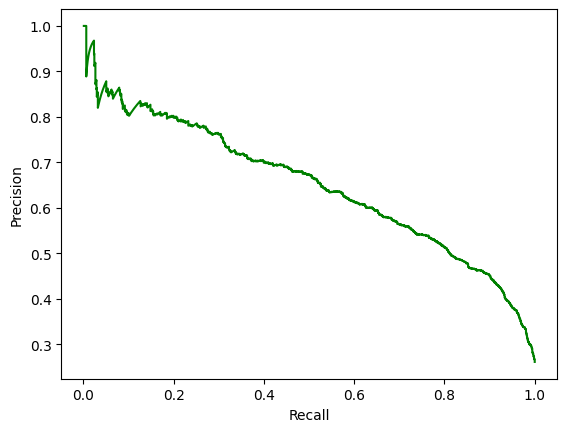

In [97]:
plt.plot(r[:-1], p[:-1], "g-")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Plotting Precision and Recall against Thresholds

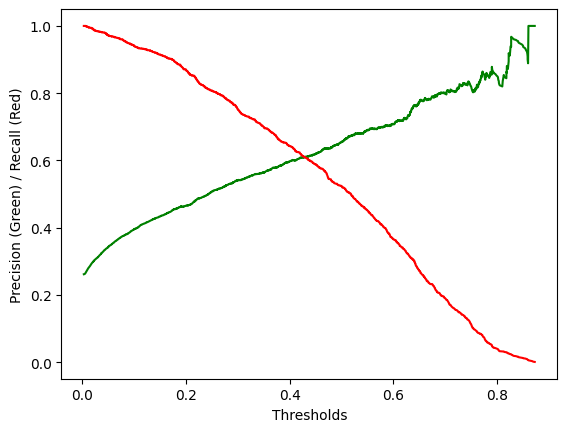

In [99]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xlabel('Thresholds')
plt.ylabel('Precision (Green) / Recall (Red)')
plt.show()

### When to use ROC vs Precision-Recall Curve

- `ROC curves` should be used when there are roughly equal numbers of observations for each class.
- `Precision-Recall` curves should be used when there is a moderate to large class imbalance.


### At this point, update our Threshold and recalculate

## Making predictions on the Test Data

In [101]:
X_test = X_test[cols_model]
X_test

,tenure,PaperlessBilling,MonthlyCharges,SeniorCitizen,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),OnlineSecurity_Yes,OnlineBackup_Yes,TechSupport_Yes,StreamingMovies_Yes
942,24,1,79.85,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3730,57,1,104.50,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1761,58,1,24.45,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2283,1,1,71.55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1872,41,0,19.70,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1289,63,0,68.80,0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3508,70,1,113.65,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
6765,69,1,25.60,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3598,1,0,46.30,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
scaler = StandardScaler()
X_train[['tenure','MonthlyCharges']] = scaler.fit_transform(X_train[['tenure','MonthlyCharges']])

In [105]:
X_test[['tenure','MonthlyCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges']])

In [106]:
list(zip(X_train1.columns, X_test.columns))

[('tenure', 'tenure'),
 ('PaperlessBilling', 'PaperlessBilling'),
 ('MonthlyCharges', 'MonthlyCharges'),
 ('SeniorCitizen', 'SeniorCitizen'),
 ('Contract_One year', 'Contract_One year'),
 ('Contract_Two year', 'Contract_Two year'),
 ('PaymentMethod_Credit card (automatic)',
  'PaymentMethod_Credit card (automatic)'),
 ('OnlineSecurity_Yes', 'OnlineSecurity_Yes'),
 ('OnlineBackup_Yes', 'OnlineBackup_Yes'),
 ('TechSupport_Yes', 'TechSupport_Yes'),
 ('StreamingMovies_Yes', 'StreamingMovies_Yes')]

Predict

In [107]:
y_test_pred = logreg.predict(X_test)

In [108]:
list(zip(y_test_pred[:10], y_test[:10]))

[(np.int64(1), 0),
 (np.int64(1), 1),
 (np.int64(0), 0),
 (np.int64(1), 1),
 (np.int64(0), 0),
 (np.int64(1), 1),
 (np.int64(1), 0),
 (np.int64(0), 0),
 (np.int64(1), 1),
 (np.int64(1), 0)]

In [109]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [110]:
# Let's see the head
y_pred_1.head()

,0
0,1
1,1
2,0
3,1
4,0


In [111]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [112]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [113]:
# Removing index for both dataframes to append them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [114]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [115]:
# Renaming the column
lr_probs_test = logreg.predict_proba(X_test)
lr_probs_test = lr_probs_test[:, 1]
y_pred_final['Churn_Prob'] = lr_probs_test
# y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [116]:
lr_probs_test

array([1.00000000e+00, 1.00000000e+00, 5.52462072e-14, ...,
       1.65814603e-17, 1.00000000e+00, 7.21280758e-19], shape=(2110,))

In [117]:
# Let's see the head of y_pred_final
y_pred_final

,Churn,CustID,0,Churn_Prob
0,0,942,1,1.000000e+00
1,1,3730,1,1.000000e+00
2,0,1761,0,5.524621e-14
3,1,2283,1,1.000000e+00
4,0,1872,0,1.610694e-09
...,...,...,...,...
2105,0,1289,1,9.703660e-01
2106,0,3508,1,1.000000e+00
2107,0,6765,0,1.658146e-17
2108,0,3598,1,1.000000e+00


In [118]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.42 else 0)

In [119]:
y_pred_final.head()

,Churn,CustID,0,Churn_Prob,final_predicted
0,0,942,1,1.000000e+00,1
1,1,3730,1,1.000000e+00,1
2,0,1761,0,5.524621e-14,0
3,1,2283,1,1.000000e+00,1
4,0,1872,0,1.610694e-09,0


In [120]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted)

0.44218009478672987

In [121]:
confusion2 = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
confusion2

array([[ 360, 1168],
       [   9,  573]])

In [122]:
TP = confusion2[1,1] # true positive
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [123]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

np.float64(0.9845360824742269)

In [124]:
# Let us calculate specificity
TN / float(TN+FP)

np.float64(0.2356020942408377)